# Entity relation scanner

Library imports

In [1]:
import wikipedia
import spacy
from spacy import displacy
import networkx as nx
import matplotlib.pyplot as plt

Download language model

In [2]:
! python -m spacy download en_core_web_sm -q

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


Load model

In [3]:
nlp = spacy.load('en_core_web_sm')

We define some hyperparameters to construct the network

In [4]:
SEEDED_ENTITY = 'Ned Stark'       # the subject entity to start constructing the graph
ENTITY_TYPES = ['PERSON']         # the types of entities that are going to be considered to extract all the relations
N_RELATIONS = 6                   # the max number of relations to be extracted per subject entity
MAX_REQUESTS = 6                  # The maximum number of entities we are going to request from Wikipedia

We run the entity extraction algorithm

In [5]:
# A list of entities to be retrieved from Wikipedia
to_visit = [SEEDED_ENTITY]

# A dictionary to store the extracted entities and relations
entities = {}

# Initializes the request's counter to limit the number of requests to Wikipedia
n_requests = 1

# The extraction algorithm runs until the 'to_visit' list is exhausted or it reaches the maximum number of requests
while to_visit and n_requests <= MAX_REQUESTS:
    
    # Get the last element of the list
    entity = to_visit.pop()
    
    # The variable 'entity_references' contains the full and the split references to the entity: 'John Doe', 'John', 'Doe'
    entity_references = [entity]
    entity_references.extend(entity.split())
    
    # Try to get the article related to the entity from wikipedia
    try:
        content = wikipedia.page(entity, auto_suggest=False).content

        # This simply checks that we got a concrete result and we were not being redirected to a disambiguation page

        # We initialize an spaCy's doc object
        doc = nlp(content)

        # A dictionary to store the extracted relations
        predicates = {}

        # We process each sentence separately
        for sent in doc.sents:

            # We try to extract the subject entity among the found entities in the sentences
            subj = False
            for ent in sent.ents:
                if ent.text in entity_references:
                    subj = ent.root

            # We only proceed if the subject entity is in the sentence, otherwise, we skip to the next sentence
            if subj:

                # We iterate again over the found entities
                for ent in sent.ents:

                    # We try to extract object entities that are different from the subject entity
                    if ent.label_ in ENTITY_TYPES and ent.text not in entity_references:

                        # We go on only if the object entities are classified as direct or indirect objects
                        obj = ent.text if ent.root.dep_ in ['iobj', 'dobj'] else False
                        if obj:

                            # Checks if the object has a verb as head
                            verb = ent.root.head.lemma_ if ent.root.head.pos_ == 'VERB' else False
                            if verb:

                                # We add the object to the predicate's list if it was not present
                                if obj not in predicates:
                                    predicates[obj] = []

                                # We add the verb to that object predictate if it was not present
                                if verb not in predicates[obj]:
                                    predicates[obj].append(verb)
                    
        # We proceed only if at least one predicate was found
        if predicates:
            
            # We order the predicates by relevance. The objects with more mentions come at the end
            ordered_by_relevance = sorted(predicates.items(), key=lambda x:len(x[1]))
            
            # The subject entity is added to the graph
            entities[entity] = []
            
            # We extract the most relevant predicates
            for relation in ordered_by_relevance[-N_RELATIONS:]:
                
                linked_entity = relation[0]
                verbs = '/'.join(relation[1]) # The list of verbs are joinded by the symbol '/'
                
                # The related entity is added to the 'to_visit' list
                to_visit = [linked_entity] + to_visit
                
                # We add the predicate to the graph
                predicate = (linked_entity, verbs)
                entities[entity].append(predicate)
                
        n_requests += 1
        
    # If the article does not exist, we simple ignore it
    except wikipedia.exceptions.PageError as e:
        pass

    # If a disambiguation error is raised, we simple ignore it 
    except wikipedia.exceptions.DisambiguationError as e:
        pass

/Users/nicolascortegosovissio/miniconda3/envs/entity_relation_scanner/lib/python3.10/site-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /Users/nicolascortegosovissio/miniconda3/envs/entity_relation_scanner/lib/python3.10/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Let's see the resulting graph

In [6]:
entities

{'Ned Stark': [('Lyanna', 'rescue'),
  ('Greensight', 'use'),
  ('Jon Arryn', 'kill'),
  ('Tyrion', 'release'),
  ('Cersei', 'neutralize'),
  ('Benjen', 'watch')],
 'Jon Arryn': [('Sansa', 'save'),
  ('Bowen', 'fear'),
  ('Ygritte', 'execute'),
  ('Lysa', 'trick/murder'),
  ('Qhorin', 'trap/kill'),
  ('Robert Baratheon', 'betroth/support/kill')],
 'Cersei': [('Joffrey', 'alienate'),
  ('Tyrion', 'implicate'),
  ('Tyrell', 'destabilise'),
  ('Loras', 'arrest'),
  ('Yara Greyjoy', 'capture'),
  ('Doom', 'replace')],
 'Ygritte': [('Jon', 'encounter/defend/shoot')],
 'Yara Greyjoy': [('Westeros', 'conquer'),
  ('Sand Snakes', 'kill'),
  ('Ellaria', 'accompany')]}

We initialize a directed graph using the class 'DiGraph' from  the networkx library

In [7]:
g = nx.DiGraph()

We get a list of all extracted entities

In [8]:
nodes = []

for entity, predicates in entities.items():
    if entity not in nodes:
        nodes.append(entity)
    for predicate in predicates:
        linked_entity = predicate[0]
        if linked_entity not in nodes:
            nodes.append(linked_entity)

nodes

['Ned Stark',
 'Lyanna',
 'Greensight',
 'Jon Arryn',
 'Tyrion',
 'Cersei',
 'Benjen',
 'Sansa',
 'Bowen',
 'Ygritte',
 'Lysa',
 'Qhorin',
 'Robert Baratheon',
 'Joffrey',
 'Tyrell',
 'Loras',
 'Yara Greyjoy',
 'Doom',
 'Jon',
 'Westeros',
 'Sand Snakes',
 'Ellaria']

We add the nodes to the graph

In [9]:
g.add_nodes_from(nodes)
g.nodes()

NodeView(('Ned Stark', 'Lyanna', 'Greensight', 'Jon Arryn', 'Tyrion', 'Cersei', 'Benjen', 'Sansa', 'Bowen', 'Ygritte', 'Lysa', 'Qhorin', 'Robert Baratheon', 'Joffrey', 'Tyrell', 'Loras', 'Yara Greyjoy', 'Doom', 'Jon', 'Westeros', 'Sand Snakes', 'Ellaria'))

We add the edges to the graph

In [10]:
for entity, predicates in entities.items():
    for predicate in predicates:
        linked_entity = predicate[0]
        g.add_edge(entity, linked_entity)

g.edges()

OutEdgeView([('Ned Stark', 'Lyanna'), ('Ned Stark', 'Greensight'), ('Ned Stark', 'Jon Arryn'), ('Ned Stark', 'Tyrion'), ('Ned Stark', 'Cersei'), ('Ned Stark', 'Benjen'), ('Jon Arryn', 'Sansa'), ('Jon Arryn', 'Bowen'), ('Jon Arryn', 'Ygritte'), ('Jon Arryn', 'Lysa'), ('Jon Arryn', 'Qhorin'), ('Jon Arryn', 'Robert Baratheon'), ('Cersei', 'Joffrey'), ('Cersei', 'Tyrion'), ('Cersei', 'Tyrell'), ('Cersei', 'Loras'), ('Cersei', 'Yara Greyjoy'), ('Cersei', 'Doom'), ('Ygritte', 'Jon'), ('Yara Greyjoy', 'Westeros'), ('Yara Greyjoy', 'Sand Snakes'), ('Yara Greyjoy', 'Ellaria')])

We create a dictionary to store the labels

In [11]:
edge_labels = {}
for entity, predicates in entities.items():
    for predicate in predicates:
        linked_entity = predicate[0]
        verbs = predicate[1]
        edge_labels[(entity, linked_entity)] = verbs

We display the graph using matplotlib

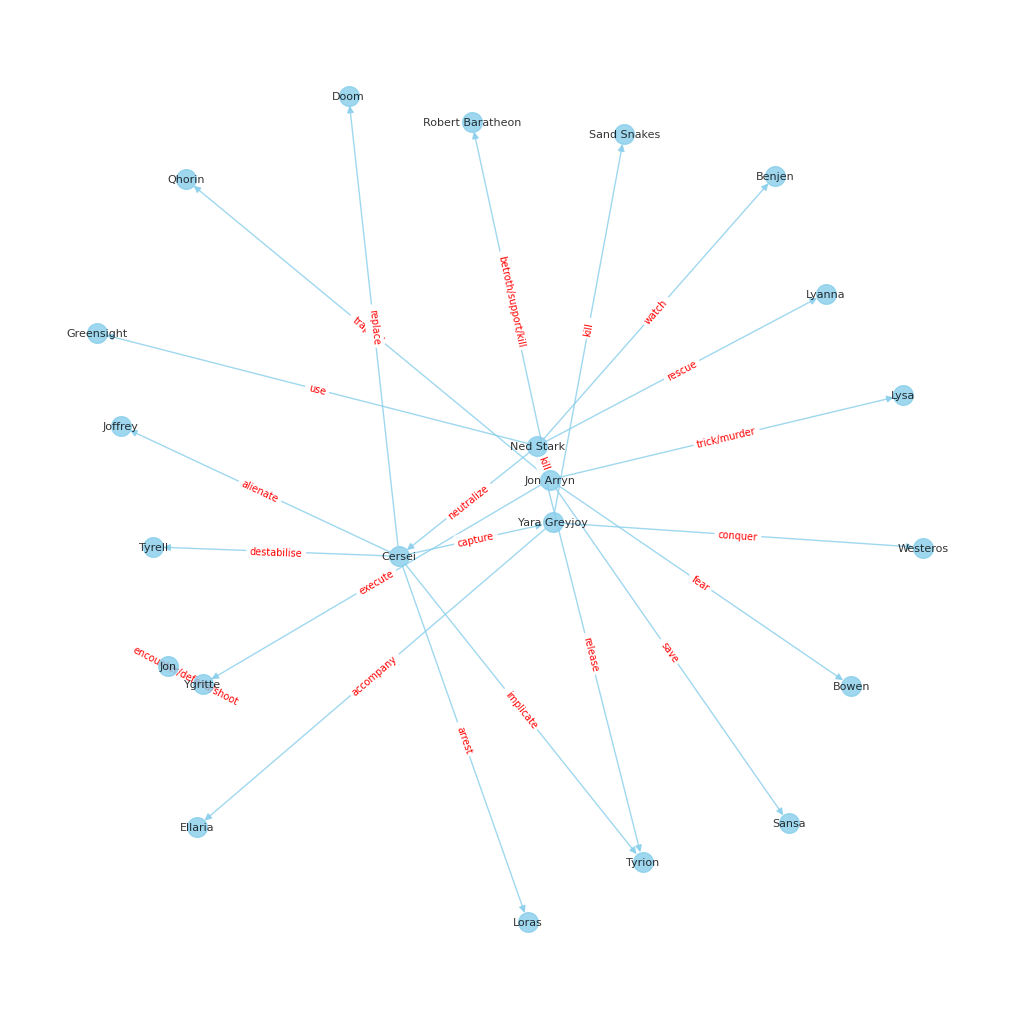

In [12]:
plt.figure(figsize=(10, 10))

pos = nx.spring_layout(g)

nx.draw(
    g, pos, edge_color='skyblue', width=1, linewidths=1, font_size=8,
    node_size=200, node_color='skyblue', alpha=0.8,
    labels={node: node for node in g.nodes()}
)

nx.draw_networkx_edge_labels(
    g, pos,
    edge_labels=edge_labels,
    font_color='red',
    font_size=7
)

plt.show()